In [7]:
import numpy as np
from scipy.special import logsumexp, betaln, gammaln
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd


def pt_d_sample_test(data1, data2, c=1, max_depth=-1, qdist=norm.ppf, aj=lambda depth: depth**2, log_BF=False):
    old_expressions = np.get_printoptions()['threshold']
    np.set_printoptions(threshold=max(max_depth, old_expressions))

    if max_depth < 0:
        max_depth = max(1, int(np.floor(np.log2(len(data1)) / 2)))

    # Combine datasets and create a group identifier
    binary = np.concatenate((np.zeros(len(data1)), np.ones(len(data2))))
    continuous = np.concatenate((data1, data2))
    data = np.column_stack([scale(continuous), binary])
    X = data[:, 0]  # assign the scaled value to X

    p_H0 = pt_marginal_likelihood(X, low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)

    discrete_values = np.unique(binary)

    p_H1 = max([pt_marginal_likelihood(data[data[:, 1] == i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj) +
                pt_marginal_likelihood(data[data[:, 1] != i, 0], low=0, up=1, c=c, depth=1, max_depth=max_depth, qdist=qdist, aj=aj)
                for i in discrete_values])

    n_hypotheses = len(discrete_values)
    logbf = p_H0 - p_H1 + np.log(n_hypotheses)
    np.set_printoptions(threshold=old_expressions)

    if log_BF:
        return logbf
    else:
        bf = np.exp(logbf)
        return bf


def pt_marginal_likelihood(data, low, up, c, depth, max_depth, qdist, aj):
    if depth == max_depth:
        return 0

    if isinstance(low, (int, float)):  # if low is an integer
        n_j = [
            np.sum((qdist(low) < data) & (data <= qdist((low + up) / 2))),
            np.sum((qdist((low + up) / 2) < data) & (data <= qdist(up)))
        ]  # counts the number of data in each interval (2 vector).
    else:
        n_j = [
            np.sum((qdist(low[0]) < data[:, 0]) & (data[:, 0] <= qdist((low[0] + up[0]) / 2)) &
                   (qdist(low[1]) < data[:, 1]) & (data[:, 1] <= qdist((low[1] + up[1]) / 2))),
            np.sum((qdist((low[0] + up[0]) / 2) < data[:, 0]) & (data[:, 0] <= qdist(up[0])) &
                   (qdist(low[1]) < data[:, 1]) & (data[:, 1] <= qdist((low[1] + up[1]) / 2))),
            np.sum((qdist(low[0]) < data[:, 0]) & (data[:, 0] <= qdist((low[0] + up[0]) / 2)) &
                   (qdist((low[1] + up[1]) / 2) < data[:, 1]) & (data[:, 1] <= qdist(up[1]))),
            np.sum((qdist((low[0] + up[0]) / 2) < data[:, 0]) & (data[:, 0] <= qdist(up[0])) &
                   (qdist((low[1] + up[1]) / 2) < data[:, 1]) & (data[:, 1] <= qdist(up[1])))
        ]  # 4 vector 

    if np.sum(n_j) == 0:
        return 0

    a_j = c * aj(depth)

    if len(n_j) == 2:
        logl = betaln(n_j[0] + a_j, n_j[1] + a_j) - betaln(a_j, a_j)  # log of beta function
    else:
        logl = lmbeta(n_j[0] + a_j, n_j[1] + a_j, n_j[2] + a_j, n_j[3] + a_j) - lmbeta(a_j, a_j, a_j, a_j)

    if isinstance(low, (int, float)):
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj)
        ]  # likelihood of subpartitions
    else:
        likelihoods = [
            pt_marginal_likelihood(data, low, (low + up) / 2, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, (low + up) / 2, up, c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, [low[0], (low[1] + up[1]) / 2], [(low[0] + up[0]) / 2, up[1]],
                                   c, depth + 1, max_depth, qdist, aj),
            pt_marginal_likelihood(data, [(low[0] + up[0]) / 2, low[1]], [up[0], (low[1] + up[1]) / 2],
                                   c, depth + 1, max_depth, qdist, aj)
        ]

    return logl + np.sum(likelihoods)


def lmbeta(*args):
    return np.sum(gammaln(args)) - gammaln(np.sum(args))


def is_discrete(X):
    return np.all(np.isin(X, np.arange(11)))  # evaluates to TRUE only if every element of X lies within the specified range of 0 to 10.


def scale(data):
    return (data - np.mean(data)) / np.std(data)


In [15]:
# Example
np.random.seed(0)
size = 500
data1 = np.random.normal(loc=0, scale=1, size=size)
data2 = np.random.normal(loc=20, scale=0.3, size=size)

#imputs: data1, data2
log_bf = pt_d_sample_test(data1, data2, log_BF=True)
print("Log Bayes Factor is:", log_bf)

Log Bayes Factor is: -683.2496569644375


# Null Case

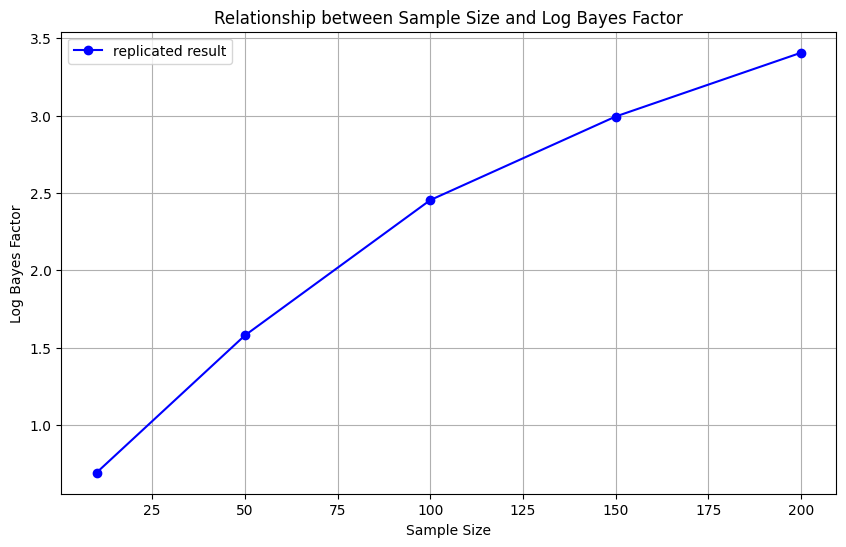

In [14]:
rep = 500
sample_sizes = [10, 50, 100, 150, 200]
size = len(sample_sizes)
bfmatrix = np.empty((size, rep))


for i in range(size):
    for j in range(rep):
        data1 = np.random.normal(loc=0, scale=1,size=sample_sizes[i])
        data2 = np.random.normal(loc=0, scale=1,size=sample_sizes[i])     
#        data2 = stats.t.rvs(1, loc=0, scale=1, size= sample_sizes[i])
 #   np.random.standard_t(df=1, size=sample_sizes[i])
        
        C = np.concatenate((np.zeros(sample_sizes[i]), np.ones(sample_sizes[i])))
        X = np.concatenate((data1, data2))

        bfmatrix[i, j] = pt_d_sample_test(data1, data2, log_BF = True)

# Calculating row means
row_means = np.mean(bfmatrix, axis=1)
#ci_lower = np.percentile(bfmatrix, 5, axis=1)
#ci_upper = np.percentile(bfmatrix, 95, axis=1)

df_original = pd.DataFrame({'SampleSize': sample_sizes, 'MeanRowValue': row_means})

# Additional data points
additional_sample_sizes = [10, 50, 100, 150, 200]
additional_row_means = [0.3896103896103895, 2.545454545454545, 4.545454545454545, 6.181818181818181, 7.7142857142857135]

df_additional = pd.DataFrame({'SampleSize': additional_sample_sizes, 'MeanRowValue': additional_row_means})

plt.figure(figsize=(10, 6))

plt.errorbar(df_original['SampleSize'], df_original['MeanRowValue'], fmt='-o', color='blue', ecolor='red', capsize=5, label='replicated result')

#plt.plot(df_additional['SampleSize'], df_additional['MeanRowValue'],  color='green', marker='x', linestyle='--', markersize=5, label='holms')

plt.xlabel('Sample Size')
plt.ylabel('Log Bayes Factor')
plt.title('Relationship between Sample Size and Log Bayes Factor')
plt.legend()
plt.grid(True)
plt.show()

# Mean Shift Case

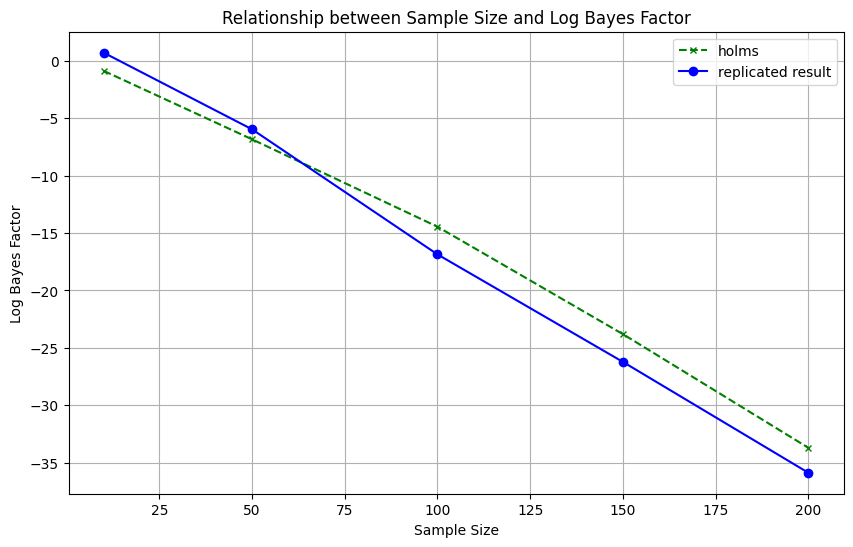

In [16]:
rep = 500
sample_sizes = [10, 50, 100, 150, 200]
size = len(sample_sizes)
bfmatrix = np.empty((size, rep))


for i in range(size):
    for j in range(rep):
        data1 = np.random.normal(loc=0, scale=1,size=sample_sizes[i])
        data2 = np.random.normal(loc=1, scale=1,size=sample_sizes[i])    #Same variance, different mean
#       data2 = stats.t.rvs(1, loc=0, scale=1, size= sample_sizes[i])
 #      np.random.standard_t(df=1, size=sample_sizes[i])
        
        C = np.concatenate((np.zeros(sample_sizes[i]), np.ones(sample_sizes[i])))
        X = np.concatenate((data1, data2))

        bfmatrix[i, j] = pt_d_sample_test(data1, data2, log_BF = True)

# Calculating row means 
row_means = np.mean(bfmatrix, axis=1)
#ci_lower = np.percentile(bfmatrix, 5, axis=1)
#ci_upper = np.percentile(bfmatrix, 95, axis=1)

df_original = pd.DataFrame({'SampleSize': sample_sizes, 'MeanRowValue': row_means})

# Holmes data points
additional_sample_sizes = [10, 50, 100, 150, 200]
additional_row_means = [-0.8899663720966604, -6.846797528740124, -14.455306170329235, -23.803081254398997, -33.69515914600766]

df_additional = pd.DataFrame({'SampleSize': additional_sample_sizes, 'MeanRowValue': additional_row_means})

# Plotting
plt.figure(figsize=(10, 6))

plt.errorbar(df_original['SampleSize'], df_original['MeanRowValue'], fmt='-o', color='blue', ecolor='red', capsize=5, label='replicated result')

plt.plot(df_additional['SampleSize'], df_additional['MeanRowValue'], 
         color='green', marker='x', linestyle='--', markersize=5, label='holms')

plt.xlabel('Sample Size')
plt.ylabel('Log Bayes Factor')
plt.title('Relationship between Sample Size and Log Bayes Factor')
plt.legend()
plt.grid(True)
plt.show()

# Variance Shift Case

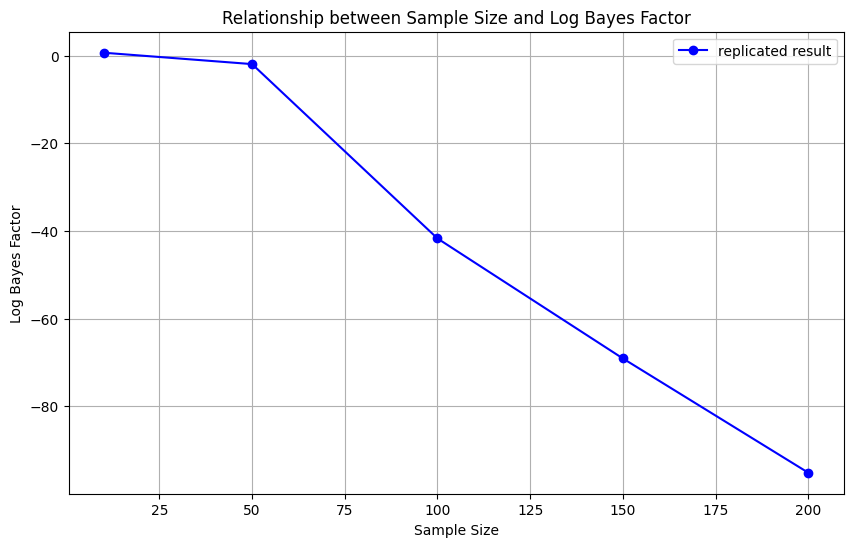

In [11]:
rep = 500
sample_sizes = [10, 50, 100, 150, 200]
size = len(sample_sizes)
bfmatrix = np.empty((size, rep))


for i in range(size):
    for j in range(rep):
        data1 = np.random.normal(loc=0, scale=1,size=sample_sizes[i])
        data2 = np.random.normal(loc=0, scale=10,size=sample_sizes[i])    #Same mean, different variance
#       data2 = stats.t.rvs(1, loc=0, scale=1, size= sample_sizes[i])
 #      np.random.standard_t(df=1, size=sample_sizes[i])
        
        C = np.concatenate((np.zeros(sample_sizes[i]), np.ones(sample_sizes[i])))
        X = np.concatenate((data1, data2))

        bfmatrix[i, j] = pt_d_sample_test(data1, data2, log_BF = True)

# Calculating row means 
row_means = np.mean(bfmatrix, axis=1)
#ci_lower = np.percentile(bfmatrix, 5, axis=1)
#ci_upper = np.percentile(bfmatrix, 95, axis=1)

df_original = pd.DataFrame({'SampleSize': sample_sizes, 'MeanRowValue': row_means})

# Holmes data points
additional_sample_sizes = [10, 50, 100, 150, 200]
additional_row_means = [-0.21315789473684355, -2.9991228070175477, -8.132456140350886, -14.665350877192992, -21.130701754385974]

df_additional = pd.DataFrame({'SampleSize': additional_sample_sizes, 'MeanRowValue': additional_row_means})

# Plotting
plt.figure(figsize=(10, 6))

plt.errorbar(df_original['SampleSize'], df_original['MeanRowValue'], fmt='-o', color='blue', ecolor='red', capsize=5, label='replicated result')

#plt.plot(df_additional['SampleSize'], df_additional['MeanRowValue'], color='green', marker='x', linestyle='--', markersize=5, label='holms')

plt.xlabel('Sample Size')
plt.ylabel('Log Bayes Factor')
plt.title('Relationship between Sample Size and Log Bayes Factor')
plt.legend()
plt.grid(True)
plt.show()